## Build network using pretrained MobileNet_V2 architecture for Self created Drone dataset

## Attempt-2: Used Pre-Trained MobileNet_V2 network where last 3 blocks are un-freezed and added own classifier layer



In [1]:
# mount gdrive
mount_drive = True
if mount_drive:
    from google.colab import drive
    drive.mount('/content/gdrive') 

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
import torch

# check the allocation manhine
isCuda = torch.cuda.is_available()
machine = torch.cuda.get_device_properties(0) if isCuda else 'cpu'
print("Assigned Machine: ", machine)
device = torch.device('cuda:0' if isCuda else 'cpu')
print(f"cuda avaiable: {isCuda}, Device: {device}")

Assigned Machine:  _CudaDeviceProperties(name='Tesla P100-PCIE-16GB', major=6, minor=0, total_memory=16280MB, multi_processor_count=56)
cuda avaiable: True, Device: cuda:0


In [3]:
import os
os.chdir('/content/gdrive/My Drive/TSAI/EVA4_Phase2/session2/')
print(os.getcwd())

/content/gdrive/My Drive/TSAI/EVA4_Phase2/session2


In [4]:
# Import standard packages
import torchvision
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
%matplotlib inline

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [5]:
import pkgutil
import importlib

# install "apex" model for mixed precision training if required.. this is needed for LRFinder
if pkgutil.find_loader("apex") is None:
   print("apex module does not exist")
   !pip install -U git+https://www.github.com/NVIDIA/apex --no-cache-dir

from utils.lr_finder import LRFinder # cutom module for LR finder

In [6]:
import albumentations # to apply image augmentation using albumentations library.
print(albumentations.__version__) # check verison

# this is to install and use albumentations latest package v0.4.5
album_version_needed = "0.4.6"
if albumentations.__version__ != album_version_needed:
  !pip install -U git+https://github.com/albu/albumentations # --no-cache-dir

0.4.6


In [10]:
# To autoreload all te custom files when modified
import autoreload
%load_ext autoreload
%autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
#import shutil
#shutil.rmtree('./logs_v2')

In [12]:
from pathlib import Path

# important folders used in this application

SOLUTION_LOG_DIR = "logs_v2_album"     # root directoy for all the log of this notebook
Path(f'./{SOLUTION_LOG_DIR}').mkdir(exist_ok=True)

SAVED_MODELS_DIR = Path(f'./{SOLUTION_LOG_DIR}/saved_models') # location to save models
SAVED_MODELS_DIR.mkdir(exist_ok=True)

SAVED_RESULTS_DIR = Path(f'./{SOLUTION_LOG_DIR}/saved_results')
SAVED_RESULTS_DIR.mkdir(exist_ok=True)

PLOT_DIR = Path(f'./{SOLUTION_LOG_DIR}/doc_images')
PLOT_DIR.mkdir(exist_ok=True)

In [13]:
from utils.common_utils import LR_UPDATE_TY

# Application specific configurations
config_params = dict(
    seed=1,
    batch_size=256,
    num_workers=6,
    epochs=25,
    lr_update_ty=LR_UPDATE_TY.EPOCHWISE,
    resume_training = False,
    load_model_path = Path(f'./{SAVED_MODELS_DIR}/ep2_testloss_1.160373000.pth'), # used when resume_training is True
)

torch.manual_seed(config_params['seed'])
if isCuda:
   torch.cuda.manual_seed(config_params['seed'])

In [14]:
# dataset path where zip files are placed
src_dataset_dir = '/content/gdrive/My Drive/TSAI/EVA4_Phase2/datasets/s2_dataset/'
#src_dataset_dir = '/content/gdrive/My Drive/TSAI/EVA4_Phase2/datasets/session2/s2_dataset_v1/'

#unzip locations: note path shall be colab internal memory location not on mounted drive.
root_dataset = '/content/eva4p2_s2_dataset'

In [15]:
import shutil
#shutil.rmtree(root_dataset)

In [16]:
class_list = ['Flying Birds', 'Large QuadCopters', 'Small QuadCopters', 'Winged Drones']
class_list_shortname = ['FB', 'LQC', 'SQC', 'WD']

# Preparing Dataset

In [17]:
# Extracting zipped dataset into colab internal memory
%%time

import zipfile
def extract_dataset(fn, dest):
    with open(fn, 'rb') as f:
      zf = zipfile.ZipFile(f)
      zf.extractall(dest)
      
# create root destination folder
if not Path(root_dataset).exists():
  Path(root_dataset).mkdir(exist_ok=True)

# extract individual class zip file
for classname in class_list:
  class_zipname = f'{src_dataset_dir}/{classname}.zip'  
  class_dir = f'{root_dataset}/{classname}' # class folder unzip location
  if not Path(class_dir).exists():
    print(f'Extracting {classname} images...')
    extract_dataset(fn=class_zipname, dest=class_dir)

CPU times: user 173 µs, sys: 0 ns, total: 173 µs
Wall time: 184 µs


In [18]:
# dataset count-summary
def get_dataset_count(roordir, classlist):
    total = 0
    for classname in classlist:
      classdir = os.path.join(roordir, classname)
      classcnt = len(os.listdir(classdir))
      total += classcnt
      print(f'{classname}: {classcnt} images')

    print(f'\nTotal images: {total}')
    return

def display_classnames(shortname_list, fullname_list):
  for shortname, fullname in zip(shortname_list, fullname_list):
    print(f'{shortname}: {fullname}') 

In [19]:
get_dataset_count(root_dataset, class_list)

Flying Birds: 8338 images
Large QuadCopters: 4169 images
Small QuadCopters: 3623 images
Winged Drones: 5675 images

Total images: 21805


# Remove all duplicate and errornous file

In [20]:
import pandas as pd
df_dataset = pd.read_csv('eda_duplicate_list.csv')
df_remove = df_dataset[(df_dataset['duplicate'] == 1) | (df_dataset['cross_duplicate'] == 1) | (df_dataset['errornous_file'] == 1)]
print(f'File to removes: {len(df_remove)}')
df_remove['classname'].value_counts()

File to removes: 2376


Winged Drones        1486
Flying Birds          407
Small QuadCopters     317
Large QuadCopters     166
Name: classname, dtype: int64

In [21]:
df_remove.head()

,filename,classname,errornous_file,duplicate,parent_img,cross_duplicate,duplicate_class
397,Flying Birds/fb_img_0430.jpg,Flying Birds,0,1,Flying Birds/flying-common-raven-picture-id117...,0,NaN
470,Flying Birds/animal-photography-bird-flying-50...,Flying Birds,0,1,Flying Birds/white-bird-50685.jpg,0,NaN
613,Flying Birds/Copy of 4d34f43aadc32f89c38c37493...,Flying Birds,0,1,Flying Birds/4d34f43aadc32f89c38c37493eed81170...,0,NaN
904,Flying Birds/ZHATuKpukACkWHz5ObmLRgHaEK.jpg,Flying Birds,0,1,Flying Birds/image132.jpg,0,NaN
958,Flying Birds/aFrDNzUEXrI.jpg,Flying Birds,0,1,Flying Birds/photo-1512830488078-82f3fda58d65.jpg,0,NaN


In [22]:
from tqdm import tqdm
def remove_files(rootdir, df_data):
    dvalues = df_data.values
    pbar = tqdm(dvalues)
    for idx, item in enumerate(pbar):
      filename = dvalues[idx][0]
      filepath = f'{rootdir}/{filename}'  
      if Path(filepath).exists():
        os.remove(filepath)
      pbar.set_description(desc=f'Removing files..')
    return

In [23]:
remove_files(root_dataset, df_remove)

Removing files..: 100%|██████████| 2376/2376 [00:02<00:00, 904.72it/s]


In [24]:
# check the final dataset summary used for model building
get_dataset_count(root_dataset, class_list)

Flying Birds: 7931 images
Large QuadCopters: 4003 images
Small QuadCopters: 3306 images
Winged Drones: 4189 images

Total images: 19429


# Prepare Data Transforms and DataLoader

In [19]:
from utils.ImageAugmentationUtils import AlbumImageAugmentation
from utils.ImageAugmentationUtils import PyTorchImageAugmentation

means, stds = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]

imgAugmentation = AlbumImageAugmentation(means, stds, size=224)
#imgAugmentation = PyTorchImageAugmentation(means, stds, size=224)

train_transforms = imgAugmentation.get_train_transform()
test_transforms = imgAugmentation.get_test_transform()

In [20]:
import utils.data_utils as dutils

dataloader_args = dict(shuffle=False, batch_size=config_params["batch_size"], num_workers=config_params["num_workers"], pin_memory=True) if isCuda else dict(shuffle=True, batch_size=8)

train_loader, test_loader = dutils.prepare_dataloader(datadir=root_dataset, 
                                               train_transforms=train_transforms, 
                                               test_transforms=test_transforms, 
                                               dataloader_args=dataloader_args, 
                                               valid_size=0.30)

print(f'Classes: {train_loader.dataset.classes}')


Total data: 19429

Training size: 13601
Testing size: 5828
Classes: ['Flying Birds', 'Large QuadCopters', 'Small QuadCopters', 'Winged Drones']


# Visualize few training images

In [21]:
from utils.plot_utils import PlotUtils

putils = PlotUtils(device, class_list_shortname, means, stds)

FB: Flying Birds
LQC: Large QuadCopters
SQC: Small QuadCopters
WD: Winged Drones


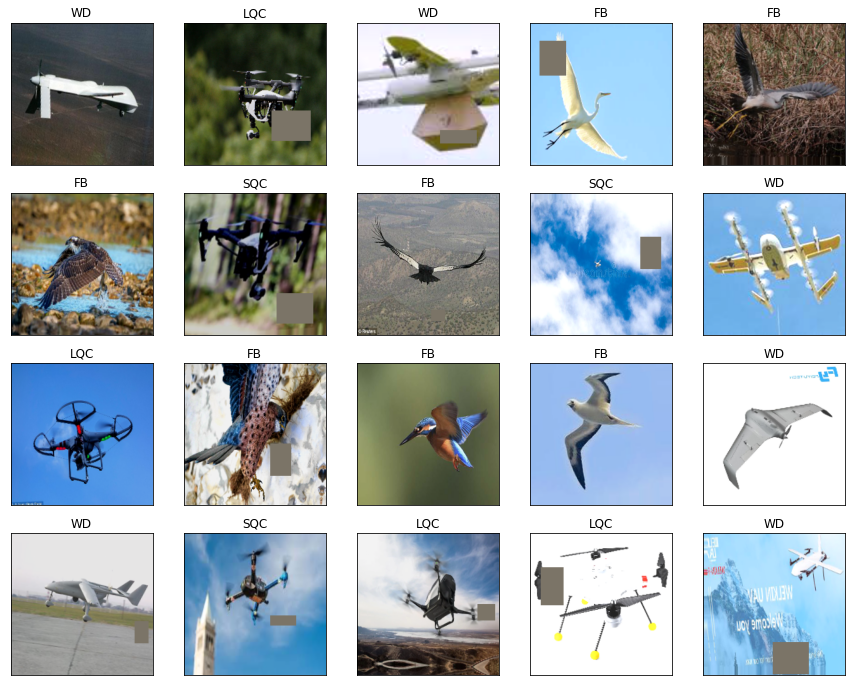

In [22]:
# visualize how image aumentation is applied on few training dataset images: 
display_classnames(class_list_shortname, class_list)
putils.plot_dataset_images(train_loader, figsize=(15,12), save_filename=f'{PLOT_DIR}/dataset_samples.jpg')

In [27]:
%time
samples = next(iter(train_loader))

# Image dimension
print(f'Image size: {samples[0][0].shape}')

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.01 µs
Image size: torch.Size([3, 224, 224])


# Pretrained MobileNet_V2 network

In [23]:
from torchvision.models import mobilenet_v2
model = mobilenet_v2(pretrained=True)
print(model)

MobileNetV2(
  (features): Sequential(
    (0): ConvBNReLU(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=Tr

### Finetuning of Pre-trianed model. Unfreeze the last 3 blocks 

In [24]:
def freeze_all_layers(model):
    for name, layer in model.named_modules():
        for parameter in layer.parameters():
          parameter.requires_grad = False

def unfreeze_layers_by_name(model, unfreeze_layer_name_list):
    for name, layer in model.named_modules():
      unfreeze = any(n in name for n in unfreeze_layer_name_list)
      if(unfreeze):
        for parameter in layer.parameters():
          parameter.requires_grad = True
      else:
        for parameter in layer.parameters():
          parameter.requires_grad = False

def unfreeze_layers_by_ids(model, unfreeze_layer_ids_list):
    # MobileNet_V2 have 19 features block accessible throunf name: features[idx]
    for idx in range(19):
      if idx in unfreeze_layer_ids_list:
        for param in model.features[idx].parameters():
          param.requires_grad = True
      else:
        for param in model.features[idx].parameters():
          param.requires_grad = False

def show_layers(model):
    for name, layer in model.named_modules():
      for parameter in layer.parameters():
        print(f'Layer name: {name}, Requires Grad: {parameter.requires_grad}')

In [25]:
unfreeze_layer_names = ['features.16', 'features.17', 'features.18', 'classifier']
unfreeze_layers_by_name(model, unfreeze_layer_names)

In [26]:
#show_layers(model)

In [27]:
#unfreeze_layers_idx = [16, 17, 18]
#unfreeze_selective_layers_by_ids(model, unfreeze_layers_idx )

In [28]:
# adding own FC and classification layer.. these layer will be trained 
model.classifier = nn.Sequential(nn.Dropout(0.2),
                                 nn.Linear(1280, 512),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(512, 1024),
                                 nn.Linear(1024, 4),
                                 nn.LogSoftmax(dim=1))

In [29]:
#show_layers(model)

In [30]:
from torchsummary import summary
model_name = "MobileNet_V2"
model = model.to(device)
summary(model, input_size=(3,224,224))
#print(model)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
             ReLU6-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
             ReLU6-6         [-1, 32, 112, 112]               0
            Conv2d-7         [-1, 16, 112, 112]             512
       BatchNorm2d-8         [-1, 16, 112, 112]              32
  InvertedResidual-9         [-1, 16, 112, 112]               0
           Conv2d-10         [-1, 96, 112, 112]           1,536
      BatchNorm2d-11         [-1, 96, 112, 112]             192
            ReLU6-12         [-1, 96, 112, 112]               0
           Conv2d-13           [-1, 96, 56, 56]             864
      BatchNorm2d-14           [-1, 96,

## LR Finder

The model is trained for num_iter iterations while the learning rate is increased from its initial value specified by the optimizer algorithm to end_lr. The increase can be linear (step_mode="linear") or exponential (step_mode="exp"); linear provides good results for small ranges while exponential is recommended for larger ranges

In [43]:
import torch.optim as optim
import torch.nn as nn

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-7, momentum=0.9, weight_decay=1e-4)
lr_finder = LRFinder(model, optimizer, criterion, device=device)
lr_finder.range_test(train_loader, end_lr=100, num_iter=200, step_mode="exp")

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


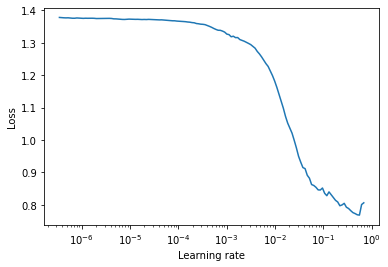

In [44]:
# Note that the loss in the loss vs. learning rate plot is the training loss.
lr_finder.plot()


In [ ]:
# To restore the model and optimizer to their initial state
lr_finder.reset()

'''
Here model is evaluated on that validation dataset after each iteration.
The evaluation loss is more sensitive to instability therefore it provides a more precise view of when the divergence occurs. 
The disadvantage is that it takes significantly longer to run
'''
lr_finder.range_test(train_loader, val_loader=test_loader, end_lr=100, num_iter=200, step_mode="exp")

In [ ]:
# Note that the loss in the loss vs. learning rate plot is the validation loss.
lr_finder.plot()

## Build and train model

In [31]:
import torch.optim as optim
from torch.optim.lr_scheduler import CyclicLR, ReduceLROnPlateau
import torch.nn.functional as F

EPOCHS = config_params['epochs']
max_lr = 0.1   # maximum LR 
min_lr = 1e-3   # minimum LR 
L2_val = 1e-4 # L2 Regularization
start_epoch = 1
step_size = 8 # num of epoch, if LR is update epoch wise
if config_params["lr_update_ty"] == LR_UPDATE_TY.BATCHWISE:
  step_size = 2000

#criterion = F.nll_loss()
criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(model.parameters(), lr=min_lr, momemtum=0.9, nesterov=True, weight_decay=L2_val) 
optimizer = optim.SGD(model.parameters(), lr=min_lr, momentum=0.9, nesterov=True, weight_decay=L2_val)  

# CyclicLR- use one cycle policy: MAX-LR at epoch=5, Triangular policy
lr_scheduler = CyclicLR(optimizer, base_lr=min_lr, max_lr=max_lr, step_size_up=step_size, step_size_down=step_size, mode='triangular2', last_epoch=-1)

# reduce LR when modle get stuck in plateu region
reduceLr_scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=4, threshold=0.001)


In [32]:
import utils.model_utils as mutils_fxn

# if resuming the traning then load the model, update optimizer states and loss state
if config_params["resume_training"] == True:
  print("This is resuming the training session...")
  model, optimizer, start_epoch, criterion = mutils_fxn.load_checkpoint(model, optimizer, device, config_params["load_model_path"])
else:
  print("This is fresh attempt training ...")

This is fresh attempt training ...


In [33]:
from utils.model_utils import ModelUtils
mutils = ModelUtils(model, 
                    device, 
                    train_loader=train_loader, 
                    test_loader=test_loader, 
                    start_epoch = start_epoch,
                    epochs=EPOCHS,
                    criterion=criterion, 
                    optimizer=optimizer,
                    lr_scheduler=lr_scheduler,
                    lr_update_ty=config_params['lr_update_ty'],
                    reduceLr_scheduler=reduceLr_scheduler,
                    saved_model_dir=SAVED_MODELS_DIR,
                    tqdm_status = True)

In [34]:
m_history = mutils.build()

  0%|          | 0/54 [00:00<?, ?it/s]

Epoch: 1 TRAIN ==> [Batch=54] train_loss=1.218000 train_acc: 40.70 LR=0.001000000: 100%|██████████| 54/54 [03:57<00:00,  4.41s/it]
  0%|          | 0/23 [00:00<?, ?it/s]
Epoch: 1 TEST  ==> [Batch=23] test_loss=0.974764 test_acc: 59.88: 100%|██████████| 23/23 [01:16<00:00,  3.32s/it]
  0%|          | 0/54 [00:00<?, ?it/s]

Epoch: 2 TRAIN ==> [Batch=54] train_loss=0.507931 train_acc: 79.70 LR=0.013375000: 100%|██████████| 54/54 [04:01<00:00,  4.47s/it]
  0%|          | 0/23 [00:00<?, ?it/s]
Epoch: 2 TEST  ==> [Batch=23] test_loss=0.374757 test_acc: 85.55: 100%|██████████| 23/23 [01:16<00:00,  3.31s/it]
  0%|          | 0/54 [00:00<?, ?it/s]

Epoch: 3 TRAIN ==> [Batch=54] train_loss=0.375139 train_acc: 84.89 LR=0.025750000: 100%|██████████| 54/54 [04:01<00:00,  4.48s/it]
  0%|          | 0/23 [00:00<?, ?it/s]
Epoch: 3 TEST  ==> [Batch=23] test_loss=0.355300 test_acc: 86.08: 100%|██████████| 23/23 [01:17<00:00,  3.38s/it]
  0%|          | 0/54 [00:00<?, ?it/s]

Epoch: 4 TRAIN ==> [Batch=54] train_loss=0.349356 train_acc: 86.19 LR=0.038125000: 100%|██████████| 54/54 [04:01<00:00,  4.47s/it]
  0%|          | 0/23 [00:00<?, ?it/s]
Epoch: 4 TEST  ==> [Batch=23] test_loss=0.324581 test_acc: 86.93: 100%|██████████| 23/23 [01:18<00:00,  3.39s/it]
  0%|          | 0/54 [00:00<?, ?it/s]

Epoch: 5 TRAIN ==> [Batch=54] train_loss=0.333126 train_acc: 86.99 LR=0.050500000: 100%|██████████| 54/54 [04:02<00:00,  4.50s/it]
  0%|          | 0/23 [00:00<?, ?it/s]
Epoch: 5 TEST  ==> [Batch=23] test_loss=0.334147 test_acc: 86.46: 100%|██████████| 23/23 [01:16<00:00,  3.33s/it]
  0%|          | 0/54 [00:00<?, ?it/s]

Epoch: 6 TRAIN ==> [Batch=54] train_loss=0.303590 train_acc: 87.83 LR=0.062875000: 100%|██████████| 54/54 [04:01<00:00,  4.47s/it]
  0%|          | 0/23 [00:00<?, ?it/s]
Epoch: 6 TEST  ==> [Batch=23] test_loss=0.338812 test_acc: 86.55: 100%|██████████| 23/23 [01:17<00:00,  3.36s/it]
  0%|          | 0/54 [00:00<?, ?it/s]

Epoch: 7 TRAIN ==> [Batch=54] train_loss=0.294591 train_acc: 88.38 LR=0.075250000: 100%|██████████| 54/54 [04:02<00:00,  4.49s/it]
  0%|          | 0/23 [00:00<?, ?it/s]
Epoch: 7 TEST  ==> [Batch=23] test_loss=0.453337 test_acc: 83.92: 100%|██████████| 23/23 [01:16<00:00,  3.35s/it]
  0%|          | 0/54 [00:00<?, ?it/s]

Epoch: 8 TRAIN ==> [Batch=54] train_loss=0.270340 train_acc: 89.16 LR=0.087625000: 100%|██████████| 54/54 [04:03<00:00,  4.51s/it]
  0%|          | 0/23 [00:00<?, ?it/s]
Epoch: 8 TEST  ==> [Batch=23] test_loss=0.333820 test_acc: 88.28: 100%|██████████| 23/23 [01:17<00:00,  3.37s/it]
  0%|          | 0/54 [00:00<?, ?it/s]

Epoch: 9 TRAIN ==> [Batch=54] train_loss=0.268956 train_acc: 89.51 LR=0.100000000: 100%|██████████| 54/54 [04:04<00:00,  4.53s/it]
  0%|          | 0/23 [00:00<?, ?it/s]
Epoch: 9 TEST  ==> [Batch=23] test_loss=0.485383 test_acc: 83.80: 100%|██████████| 23/23 [01:17<00:00,  3.36s/it]
  0%|          | 0/54 [00:00<?, ?it/s]

Epoch: 10 TRAIN ==> [Batch=54] train_loss=0.248314 train_acc: 90.16 LR=0.008762500: 100%|██████████| 54/54 [04:00<00:00,  4.46s/it]
  0%|          | 0/23 [00:00<?, ?it/s]
Epoch: 10 TEST  ==> [Batch=23] test_loss=0.297797 test_acc: 89.55: 100%|██████████| 23/23 [01:16<00:00,  3.34s/it]
  0%|          | 0/54 [00:00<?, ?it/s]

Epoch: 11 TRAIN ==> [Batch=54] train_loss=0.236469 train_acc: 91.01 LR=0.075250000: 100%|██████████| 54/54 [04:00<00:00,  4.46s/it]
  0%|          | 0/23 [00:00<?, ?it/s]
Epoch: 11 TEST  ==> [Batch=23] test_loss=0.400068 test_acc: 85.90: 100%|██████████| 23/23 [01:19<00:00,  3.45s/it]
  0%|          | 0/54 [00:00<?, ?it/s]

Epoch: 12 TRAIN ==> [Batch=54] train_loss=0.226121 train_acc: 91.28 LR=0.062875000: 100%|██████████| 54/54 [04:00<00:00,  4.45s/it]
  0%|          | 0/23 [00:00<?, ?it/s]
Epoch: 12 TEST  ==> [Batch=23] test_loss=0.361927 test_acc: 87.42: 100%|██████████| 23/23 [01:19<00:00,  3.44s/it]
  0%|          | 0/54 [00:00<?, ?it/s]

Epoch: 13 TRAIN ==> [Batch=54] train_loss=0.200241 train_acc: 92.05 LR=0.050500000: 100%|██████████| 54/54 [04:06<00:00,  4.57s/it]
  0%|          | 0/23 [00:00<?, ?it/s]
Epoch: 13 TEST  ==> [Batch=23] test_loss=0.378682 test_acc: 87.46: 100%|██████████| 23/23 [01:21<00:00,  3.54s/it]
  0%|          | 0/54 [00:00<?, ?it/s]

Epoch: 14 TRAIN ==> [Batch=54] train_loss=0.197241 train_acc: 92.37 LR=0.038125000: 100%|██████████| 54/54 [04:12<00:00,  4.68s/it]
  0%|          | 0/23 [00:00<?, ?it/s]
Epoch: 14 TEST  ==> [Batch=23] test_loss=0.330076 test_acc: 88.71: 100%|██████████| 23/23 [01:20<00:00,  3.49s/it]
  0%|          | 0/54 [00:00<?, ?it/s]

Epoch: 15 TRAIN ==> [Batch=54] train_loss=0.168893 train_acc: 93.14 LR=0.025750000: 100%|██████████| 54/54 [04:19<00:00,  4.81s/it]
  0%|          | 0/23 [00:00<?, ?it/s]
Epoch: 15 TEST  ==> [Batch=23] test_loss=0.332148 test_acc: 88.98: 100%|██████████| 23/23 [01:24<00:00,  3.67s/it]
  0%|          | 0/54 [00:00<?, ?it/s]

Epoch: 16 TRAIN ==> [Batch=54] train_loss=0.144428 train_acc: 94.27 LR=0.001337500: 100%|██████████| 54/54 [04:16<00:00,  4.76s/it]
  0%|          | 0/23 [00:00<?, ?it/s]
Epoch: 16 TEST  ==> [Batch=23] test_loss=0.323513 test_acc: 89.76: 100%|██████████| 23/23 [01:23<00:00,  3.62s/it]
  0%|          | 0/54 [00:00<?, ?it/s]

Epoch: 17 TRAIN ==> [Batch=54] train_loss=0.139961 train_acc: 94.66 LR=0.001000000: 100%|██████████| 54/54 [04:15<00:00,  4.73s/it]
  0%|          | 0/23 [00:00<?, ?it/s]
Epoch: 17 TEST  ==> [Batch=23] test_loss=0.327479 test_acc: 89.74: 100%|██████████| 23/23 [01:23<00:00,  3.63s/it]
  0%|          | 0/54 [00:00<?, ?it/s]

Epoch: 18 TRAIN ==> [Batch=54] train_loss=0.135398 train_acc: 94.63 LR=0.007187500: 100%|██████████| 54/54 [04:13<00:00,  4.69s/it]
  0%|          | 0/23 [00:00<?, ?it/s]
Epoch: 18 TEST  ==> [Batch=23] test_loss=0.339814 test_acc: 89.82: 100%|██████████| 23/23 [01:22<00:00,  3.60s/it]
  0%|          | 0/54 [00:00<?, ?it/s]

Epoch: 19 TRAIN ==> [Batch=54] train_loss=0.128540 train_acc: 94.90 LR=0.013375000: 100%|██████████| 54/54 [04:13<00:00,  4.69s/it]
  0%|          | 0/23 [00:00<?, ?it/s]
Epoch: 19 TEST  ==> [Batch=23] test_loss=0.354514 test_acc: 89.60: 100%|██████████| 23/23 [01:23<00:00,  3.61s/it]
  0%|          | 0/54 [00:00<?, ?it/s]

Epoch: 20 TRAIN ==> [Batch=54] train_loss=0.141560 train_acc: 94.58 LR=0.019562500: 100%|██████████| 54/54 [04:19<00:00,  4.80s/it]
  0%|          | 0/23 [00:00<?, ?it/s]
Epoch: 20 TEST  ==> [Batch=23] test_loss=0.384494 test_acc: 89.36: 100%|██████████| 23/23 [01:23<00:00,  3.64s/it]
  0%|          | 0/54 [00:00<?, ?it/s]

Epoch: 21 TRAIN ==> [Batch=54] train_loss=0.118751 train_acc: 95.20 LR=0.002575000: 100%|██████████| 54/54 [04:18<00:00,  4.79s/it]
  0%|          | 0/23 [00:00<?, ?it/s]
Epoch: 21 TEST  ==> [Batch=23] test_loss=0.351904 test_acc: 89.74: 100%|██████████| 23/23 [01:23<00:00,  3.65s/it]
  0%|          | 0/54 [00:00<?, ?it/s]

Epoch: 22 TRAIN ==> [Batch=54] train_loss=0.141889 train_acc: 94.38 LR=0.031937500: 100%|██████████| 54/54 [04:23<00:00,  4.88s/it]
  0%|          | 0/23 [00:00<?, ?it/s]
Epoch: 22 TEST  ==> [Batch=23] test_loss=0.378124 test_acc: 89.10: 100%|██████████| 23/23 [01:24<00:00,  3.68s/it]
  0%|          | 0/54 [00:00<?, ?it/s]

Epoch: 23 TRAIN ==> [Batch=54] train_loss=0.148543 train_acc: 94.44 LR=0.038125000: 100%|██████████| 54/54 [04:17<00:00,  4.78s/it]
  0%|          | 0/23 [00:00<?, ?it/s]
Epoch: 23 TEST  ==> [Batch=23] test_loss=0.441729 test_acc: 86.86: 100%|██████████| 23/23 [01:23<00:00,  3.62s/it]
  0%|          | 0/54 [00:00<?, ?it/s]

Epoch: 24 TRAIN ==> [Batch=54] train_loss=0.176097 train_acc: 93.14 LR=0.044312500: 100%|██████████| 54/54 [04:16<00:00,  4.76s/it]
  0%|          | 0/23 [00:00<?, ?it/s]
Epoch: 24 TEST  ==> [Batch=23] test_loss=0.377987 test_acc: 88.50: 100%|██████████| 23/23 [01:24<00:00,  3.69s/it]
  0%|          | 0/54 [00:00<?, ?it/s]

Epoch: 25 TRAIN ==> [Batch=54] train_loss=0.162970 train_acc: 93.65 LR=0.050500000: 100%|██████████| 54/54 [04:21<00:00,  4.85s/it]
  0%|          | 0/23 [00:00<?, ?it/s]
Epoch: 25 TEST  ==> [Batch=23] test_loss=0.350358 test_acc: 88.32: 100%|██████████| 23/23 [01:22<00:00,  3.57s/it]


In [41]:
m_history.result_summary()

Training best result: Accuracy: 95.20 at Epoch 21
Testing  best result: Accuracy: 89.82 at Epoch 18
Acuracy Gap: 5.38


In [35]:
best_model = torch.load(f'{SAVED_MODELS_DIR}/bestmodel.pt')

In [42]:
import utils.model_utils as mutils_fxn
testacc, testsize = mutils_fxn.get_test_accuracy(best_model, device, test_loader)
#print(f'Accuracy of the model on the {testsize} test images: {testacc:0.2f}%')

In [37]:
mutils_fxn.get_class_based_accuracy(best_model, device, test_loader, class_list)

Accuracy of Flying Birds : 100.00%
Accuracy of Large QuadCopters : 80.95%
Accuracy of Small QuadCopters : 62.50%
Accuracy of Winged Drones : 80.00%


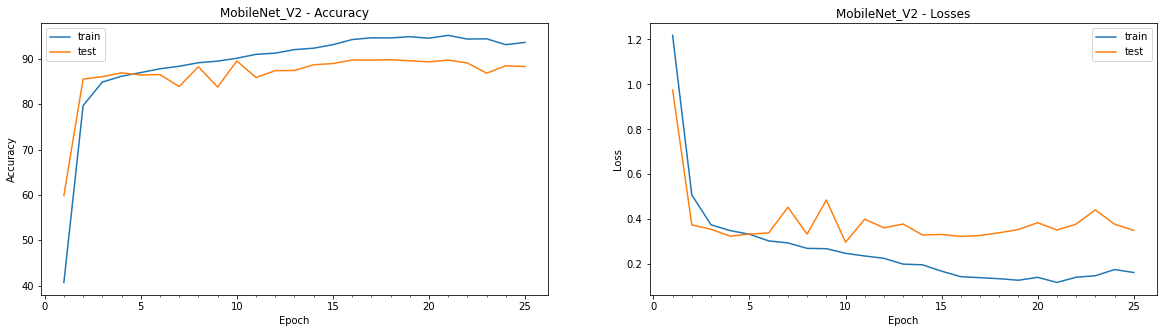

In [38]:
# Accurracy and loss history plot
m_history.plot_history(title=model_name, save_filename=f'{PLOT_DIR}/model_history.jpg')

# Visualize few misclassified images

Ploting misclassified images:

Abbrevation used: 
T: Target, P: Prediction
FB: Flying Birds
LQC: Large QuadCopters
SQC: Small QuadCopters
WD: Winged Drones


Misclassification for Flying Birds..
Misclassification for Large QuadCopters..
Misclassification for Small QuadCopters..
Misclassification for Winged Drones..
CPU times: user 3.03 s, sys: 2.05 s, total: 5.08 s
Wall time: 3min 5s


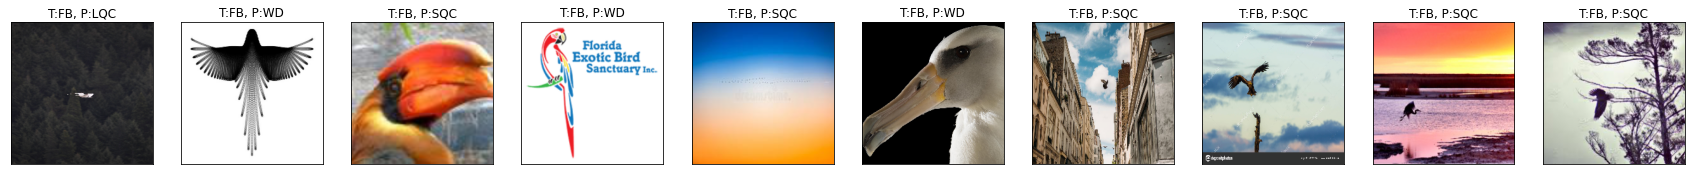

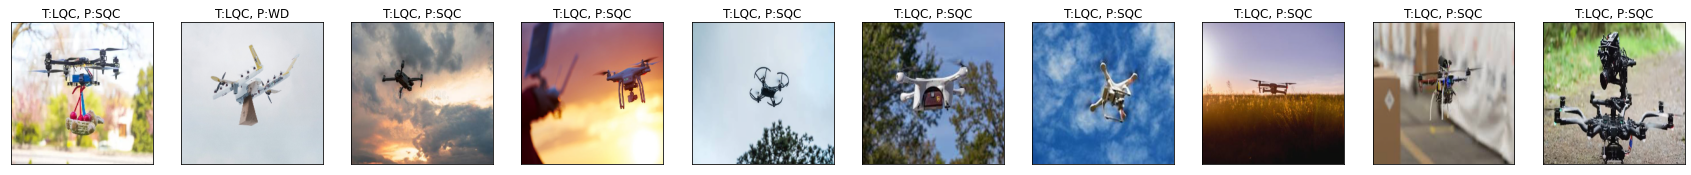

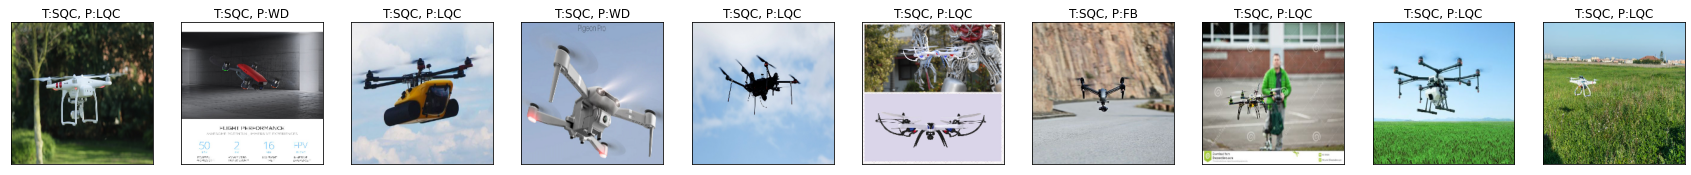

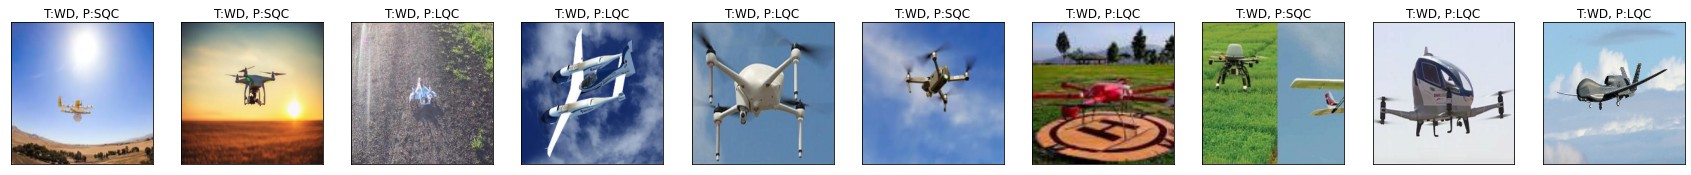

In [39]:
%%time
print('Ploting misclassified images:\n')

print('Abbrevation used: \nT: Target, P: Prediction')
display_classnames(class_list_shortname, class_list)
print('\n')
for idx, name in enumerate(class_list):
  print(f'Misclassification for {name}..')
  putils.plot_misclassified_images_for_class(best_model, 
                                             testloader=test_loader, 
                                              classid=idx,
                                              figsize=(30,3),
                                              num_of_images=10, nrow=1, 
                                              save_filename=f'{PLOT_DIR}/{name}_misclassified_images.jpg')